In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [2]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from model_v2 import *
from data_gen import *

In [4]:
%load_ext autoreload
%autoreload 2

## Data Gen

In [5]:
# Checks if all the values of the two tensors are close together, using torch.isclose()

def checkTensorClose(tensor1, tensor2, atol):
    val_close = torch.sum(torch.isclose(tensor1, tensor2, atol=atol))
    bool_val = torch.sum(val_close) == torch.numel(tensor1)
    return bool_val.item()

In [6]:
# This allows you to look into trainloader and the data returned.

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
i1, l1 = next(iter(trainloader))
print(torch.max(X_train))
print(torch.min(X_train))
print(torch.max(y_train))
print(torch.min(y_train))

NameError: name 'train_data' is not defined

In [33]:
# Normalized training data from get_train_data()
X_train, y_train = get_train_data([5000, 5000])

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()


train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

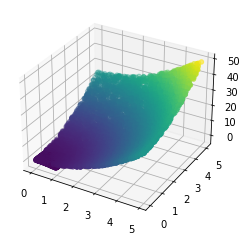

In [34]:
# Plotting the training data, unnormalized
X_train_orig, y_train_orig = unnormalize_data(X_train, y_train, cache["X_train_mean"], cache["X_train_std"], cache["y_train_mean"], cache["y_train_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_train_orig, c=y_train_orig)

## Model

In [35]:
emb_dims = [2,10]

# Always keep batch size in powers of 2, trainloader is faster this way.
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [36]:
# Use dropout of at least 0.1, maximum of 0.5
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[8, 16, 32, 16, 8, 4], output_size=1, hidden_drop_p=0, batch_flag=False)

n_epochs = 100
loss_values = []
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

t = tqdm(range(n_epochs), miniters=100)
for epoch in t:
    total_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2].long()
        preds = model(cont_x, cat_x)
        # loss = criterion(preds, nn.BatchNorm1d(1, affine=False)(labels.view(-1,1)))

        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t.set_description(f"----- Epoch: {epoch}/{n_epochs} Loss: {total_loss/num_batches} -----")
    loss_values.append(total_loss/num_batches)

----- Epoch: 99/100 Loss: 0.0012645275609072628 -----: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


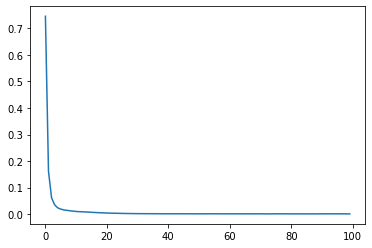

In [37]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)

Total Loss on test split A: 1.6947673559188843


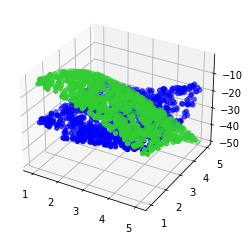

In [38]:
# Testing Split A
X_testA, y_testA = get_test_splitA(1000)
X_testA_orig, y_testA_orig = unnormalize_data(X_testA, y_testA, cache["X_testA_mean"], cache["X_testA_std"], cache["y_testA_mean"], cache["y_testA_std"])

X_testA = torch.tensor(X_testA).float()
y_testA = torch.tensor(y_testA).view(-1, 1).float()

total_loss = 0

with torch.no_grad():
    predsA = model(X_testA[:,:2].float(), X_testA[:,2].long())
    total_loss = criterion(predsA, y_testA).item()

print(f"Total Loss on test split A: {total_loss}")

X_testA_orig, predsA_orig = unnormalize_data(X_testA, predsA.detach().numpy(), cache["X_testA_mean"], cache["X_testA_std"], cache["y_testA_mean"], cache["y_testA_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], y_testA_orig, c='limegreen')
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], predsA_orig, c='blue')


Total Loss on test split B: 0.14460505545139313


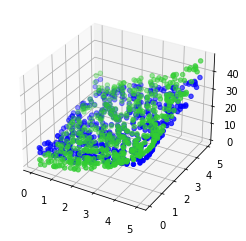

In [39]:
# Testing Split B
X_testB, y_testB = get_test_splitB([500,0])

X_testB_orig, y_testB_orig = unnormalize_data(X_testB, y_testB, cache["X_testB_mean"], cache["X_testB_std"], cache["y_testB_mean"], cache["y_testB_std"])

X_testB = torch.tensor(X_testB).float()
y_testB = torch.tensor(y_testB).view(-1, 1).float()

total_loss = 0

with torch.no_grad():
    predsB = model(X_testB[:,:2].float(), X_testB[:,2].long())
    total_loss = criterion(predsB, y_testB).item()

print(f"Total Loss on test split B: {total_loss}")

X_testB_orig, predsB_orig = unnormalize_data(X_testB, predsB.detach().numpy(), cache["X_testB_mean"], cache["X_testB_std"], cache["y_testB_mean"], cache["y_testB_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], y_testB_orig, c='limegreen')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], predsB_orig, c='blue')


Total Loss on test split C: 0.2101404070854187


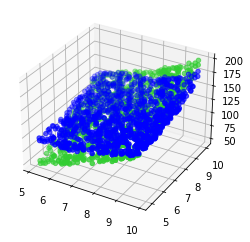

In [40]:
# Testing Split C
X_testC, y_testC = get_test_splitC(1000)

X_testC_orig, y_testC_orig = unnormalize_data(X_testC, y_testC, cache["X_testC_mean"], cache["X_testC_std"], cache["y_testC_mean"], cache["y_testC_std"])

X_testC = torch.tensor(X_testC).float()
y_testC = torch.tensor(y_testC).view(-1, 1).float()

total_loss = 0

with torch.no_grad():
    predsC = model(X_testC[:,:2].float(), X_testC[:,2].long())
    total_loss = criterion(predsC, y_testC).item()

print(f"Total Loss on test split C: {total_loss}")

X_testC_orig, predsC_orig = unnormalize_data(X_testC, predsC.detach().numpy(), cache["X_testC_mean"], cache["X_testC_std"], cache["y_testC_mean"], cache["y_testC_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], y_testC_orig, c='limegreen')
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], predsC_orig, c='blue')